This notebook includes several parts of code to generate several analysis for the ski camera detections, bot for spatial and temporal analysis. In particular:

- generate heatmaps for the detections, based on the bounding boxes;
- generate heatmaps for a partitioned map of the image;
- generate temporal analysis for average detections for each day of the weekand respective heatmaps.

All sections have a flag SAVE_IMAGES which can be modified in case one wants to save the output images or only visualize them, and some have a NORMALIZE_HEATMAPS flag to let the heatmap output be normalized (meaning that it sums to 1)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cams = ('jervskogen_1', 'jervskogen_2', 'nilsbyen_2', 'nilsbyen_3', 'skistua')

data = dict()
for cam in cams:
    data[cam] = pd.read_csv('../data/datasets/'+cam+'.csv')

# 1) All detections

# Spatial analysis

## Detection heatmap (whole image)

This section generates a heatmap of detections in the whole image, i.e., it starts with an all zero matrix and iterates over all detections, incrementing the region of the matrix inside the respective bounding box. One can use any resolution for the matrix as the detections are normalized in the dataset.

In [ ]:
SAVE_IMAGES = True

min_conf = 0.5
max_conf = 1

width = 640
height = 480

#cams = ('jervskogen_1', 'jervskogen_2', 'nilsbyen_2', 'nilsbyen_3', 'skistua')

for cam in cams:
    df = data[cam]
    detect_heatmap_bbox = np.zeros([height, width])

    for index, row in df.iterrows():
        if row['class']=='person' and min_conf < row['conf'] <= max_conf:
            p1x = round(row.p1x*width)
            p1y = round(row.p1y*height)
            p2x = round(row.p2x*width)
            p2y = round(row.p2y*height)
    
            for x in range(p1x - 1, p2x):
                for y in range(p1y - 1, p2y):
                    detect_heatmap_bbox[y, x] += 1
                
    ax = sns.heatmap(detect_heatmap_bbox, xticklabels=False, yticklabels=False, cmap='Reds')
    plt.title(cam)
    #plt.show()

    if SAVE_IMAGES:
        plt.savefig('outputs/' + 'global_heatmap_' + cam + '.jpg', dpi=300, format='jpg')
        
    plt.clf()

## Detection heatmap (partitioned; incremented with all detections; "fast")

Similar to the previous section, but here we assume a partition of the image into a small number of sections and increment all the sections which are touched by the bounding box.

Note: For large number of partitions this method outputs similar results to the previous, but not for smaller number of partitions. I consider this to be more accurate as it uses a partition of the space based on equal sized bins, while the other rounds the position in the image. I am keeping both but will probably remove the first method and stick to this one.

In [2]:
SAVE_IMAGES = True
NORMALIZE_HEATMAPS = False

min_conf = 0.5
max_conf = 1

width = 11
height = 6

#cams = ('jervskogen_1', 'jervskogen_2', 'nilsbyen_2', 'nilsbyen_3', 'skistua')

for cam in cams:

    df = data[cam]
    df = df[(df['class']=='person') & (df['conf']>min_conf)]

    detect_heatmap_partition = np.zeros([height, width])

    # Create bins between 0 and 1 to use normalized detection points
    bins_x = np.linspace(0, 1, num=width+1, endpoint=True)
    bins_y = np.linspace(0, 1, num=height+1, endpoint=True)
    
    df['pd1x'] = np.digitize(df.p1x,bins_x,right=True)-1
    df['pd1y'] = np.digitize(df.p1y,bins_y,right=True)-1
    df['pd2x'] = np.digitize(df.p2x,bins_x,right=True)-1
    df['pd2y'] = np.digitize(df.p2y,bins_y,right=True)-1
    
    for index, row in df.iterrows():
        detect_heatmap_partition[np.ix_(np.arange(row['pd1y'],row['pd2y']+1),np.arange(row['pd1x'],row['pd2x']+1))] += 1

    if NORMALIZE_HEATMAPS:
        detect_heatmap_partition = detect_heatmap_partition/detect_heatmap_partition.sum()
        
    ax = sns.heatmap(detect_heatmap_partition, xticklabels=False, yticklabels=False, cmap='Reds')
    plt.title(cam)

    if SAVE_IMAGES:
        plt.savefig('outputs/' + 'partition_heatmap_fast_' + cam + '.jpg', dpi=300, format='jpg')
    
    plt.clf()

/tmp/ipykernel_22132/1640215762.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pd1x'] = np.digitize(df.p1x,bins_x,right=True)-1
/tmp/ipykernel_22132/1640215762.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pd1y'] = np.digitize(df.p1y,bins_y,right=True)-1
/tmp/ipykernel_22132/1640215762.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

<Figure size 432x288 with 0 Axes>

## Detection heatmap (partitioned; incremented with all detections; "slow")

In [ ]:
SAVE_IMAGES = True
NORMALIZE_HEATMAPS = True

min_conf = 0.5
max_conf = 1

width = 11
height = 6

#cams = ('jervskogen_1', 'jervskogen_2', 'nilsbyen_2', 'nilsbyen_3', 'skistua')

for cam in cams:

    df = data[cam]

    detect_heatmap_partition = np.zeros([height, width])

    # Create bins between 0 and 1 to use normalized detection points
    bins_x = np.linspace(0, 1, num=width+1, endpoint=True)
    bins_y = np.linspace(0, 1, num=height+1, endpoint=True)

    for index, row in df.iterrows():
        if row['class'] == 'person' and min_conf < row['conf'] <= max_conf:
            # Top left point
            p1 = [row.p1x, row.p1y]

            pd1 = [np.digitize(p1[0],bins_x, right=True) - 1, np.digitize(p1[1],bins_y,right=True) - 1]
            
            # Bottom right point
            
            p2 = [row.p2x, row.p2y]

            pd2 = [np.digitize(p2[0],bins_x,right=True) - 1, np.digitize(p2[1],bins_y,right=True) - 1]
            
            # Increment heatmap matrix
            detect_heatmap_partition[np.ix_(np.arange(pd1[1],pd2[1]+1),np.arange(pd1[0],pd2[0]+1))] += 1

    if NORMALIZE_HEATMAPS:
        detect_heatmap_partition = detect_heatmap_partition/detect_heatmap_partition.sum()
        
    ax = sns.heatmap(detect_heatmap_partition, xticklabels=False, yticklabels=False, cmap='Reds')
    plt.title(cam)

    if SAVE_IMAGES:
        plt.savefig('outputs/' + 'partition_heatmap_' + cam + '.jpg', dpi=300, format='jpg')
    
    plt.clf()

# Temporal analysis

This section has code to analyse the detection of skiers along temporal axis. It starts by resampling the dataframe to obtain the number of detections per time period (for now, 1 hour is used) and prints averages of detections per hour for every weekday. Then, this information is summarized in a temporal heatmap, with hour and weekday in the axis.

In [ ]:
SAVE_IMAGES = True
NORMALIZE_HEATMAPS = True

# cams = ('jervskogen_1', 'jervskogen_2', 'nilsbyen_2', 'nilsbyen_3', 'skistua')

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for cam in cams:
    df_cam = data[cam]
    df_cam = df_cam[(df_cam['class']=='person') & (df_cam['conf']>0.5)]
    df_cam['timestamp'] = pd.to_datetime(df_cam['timestamp'])

    df_tmp = pd.DataFrame()
    df_tmp['value'] = df_cam['timestamp'].sort_values().value_counts(sort=False).resample('H',label='right').sum()
    df_tmp = df_tmp.groupby([df_tmp.index.weekday,df_tmp.index.hour]).mean()
    df_tmp.index = df_tmp.index.set_levels(levels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], level=0)
    df_tmp = df_tmp.unstack(level=0)
    
    df_agg = pd.DataFrame()
    df_agg['value'] = df_cam['timestamp'].sort_values().value_counts(sort=False).resample('H',label='right').sum()
    df_stats = pd.DataFrame()
    df_stats['mean'] = df_agg['value'].groupby([df_agg.index.weekday,df_agg.index.hour]).mean()
    df_stats['std'] = df_agg['value'].groupby([df_agg.index.weekday,df_agg.index.hour]).std()
    df_stats['median'] = df_agg['value'].groupby([df_agg.index.weekday,df_agg.index.hour]).median()
    df_stats.index = df_stats.index.set_levels(levels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], level=0)
    df_stats = df_stats.unstack(level=0)

    ax = df_stats['mean'].plot(kind='bar', subplots=True, rot=0, figsize=(20, 10), layout=(3, 3), sharey=True,  yerr=df_stats['std'], capsize=4)

    if SAVE_IMAGES:
        plt.savefig('outputs/' + 'temporal_analysis_' + cam + '.jpg', dpi=300, format='jpg')
        
    plt.clf()
    
    plt.figure()
    
    if NORMALIZE_HEATMAPS:
        df_stats['mean'] = df_stats['mean']/df_stats['mean'].sum()
        
    sns.heatmap(df_stats['mean'], xticklabels=True, yticklabels=True, cmap='Reds')
    plt.savefig('outputs/' +'temporal_heatmap_' + cam + '.jpg', dpi=300, format='jpg')
    
    plt.clf()
    
    df_agg['weekday'] = df_agg.index.weekday
    df_agg['weekday'] = df_agg['weekday'].replace({0: 'Monday',
                                                   1: 'Tuesday',
                                                   2: 'Wednesday',
                                                   3: 'Thursday',
                                                   4: 'Friday',
                                                   5: 'Saturday',
                                                   6: 'Sunday'})
    df_agg['hour'] = df_agg.index.hour
    sns.catplot(x='hour',y='value',data=df_agg, col='weekday', orient="v", kind='box', color='r',  col_wrap=3, height=5, aspect=1.5, col_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    plt.savefig('outputs/' +'temporal_boxplot_' + cam + '.jpg', dpi=300, format='jpg')
    
    plt.clf()

# 2) Yes/no detection

## Spatial Detection heatmap (partitioned; incremented with yes/no)

Pretty much the same as the previous partitioned heatmap, but heatmap objective is to measure whether there was a detection or not independently of how many people are actually detected.

In [4]:
SAVE_IMAGES = True
NORMALIZE_HEATMAPS = False

min_conf = 0.5
max_conf = 1

width = 11
height = 6

#cams = ('jervskogen_1', 'jervskogen_2', 'nilsbyen_2', 'nilsbyen_3', 'skistua')

for cam in cams:

    df = data[cam]
    df = df[(df['class']=='person') & (df['conf']>min_conf)]

    detect_heatmap_partition = np.zeros([height, width])

    # Create bins between 0 and 1 to use normalized detection points
    bins_x = np.linspace(0, 1, num=width+1, endpoint=True)
    bins_y = np.linspace(0, 1, num=height+1, endpoint=True)
    
    df['pd1x'] = np.digitize(df.p1x,bins_x,right=True)-1
    df['pd1y'] = np.digitize(df.p1y,bins_y,right=True)-1
    df['pd2x'] = np.digitize(df.p2x,bins_x,right=True)-1
    df['pd2y'] = np.digitize(df.p2y,bins_y,right=True)-1
    
    current_time = df.iloc[0]['timestamp']
    time_detections = np.zeros([height, width])
    for index, row in df.iterrows():
        if row['timestamp'] != current_time:
            current_time = row['timestamp']
            detect_heatmap_partition += time_detections
            time_detections = np.zeros([height, width])
        
        time_detections[np.ix_(np.arange(row['pd1y'],row['pd2y']+1),np.arange(row['pd1x'],row['pd2x']+1))] += 1
        time_detections[time_detections>0]=1

    if NORMALIZE_HEATMAPS:
        detect_heatmap_partition = detect_heatmap_partition/detect_heatmap_partition.sum()
        
    ax = sns.heatmap(detect_heatmap_partition, xticklabels=False, yticklabels=False, cmap='Reds')
    plt.title(cam)

    if SAVE_IMAGES:
        plt.savefig('outputs/' + 'partition_heatmap_single_' + cam + '.jpg', dpi=300, format='jpg')
    
    plt.clf()

/tmp/ipykernel_452064/3513764519.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pd1x'] = np.digitize(df.p1x,bins_x,right=True)-1
/tmp/ipykernel_452064/3513764519.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pd1y'] = np.digitize(df.p1y,bins_y,right=True)-1
/tmp/ipykernel_452064/3513764519.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

<Figure size 432x288 with 0 Axes>

# Temporal analysis

In [9]:
SAVE_IMAGES = True
NORMALIZE_HEATMAPS = True

# cams = ('jervskogen_1', 'jervskogen_2', 'nilsbyen_2', 'nilsbyen_3', 'skistua')

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for cam in cams:
    df_cam = data[cam]
    df_cam = df_cam.drop_duplicates(subset='timestamp')
    df_cam = df_cam[(df_cam['class']=='person') & (df_cam['conf']>0.5)]
    df_cam['timestamp'] = pd.to_datetime(df_cam['timestamp'])

    df_tmp = pd.DataFrame()
    df_tmp['value'] = df_cam['timestamp'].sort_values().value_counts(sort=False).resample('H',label='right').sum()
    df_tmp = df_tmp.groupby([df_tmp.index.weekday,df_tmp.index.hour]).mean()
    df_tmp.index = df_tmp.index.set_levels(levels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], level=0)
    df_tmp = df_tmp.unstack(level=0)
    
    df_agg = pd.DataFrame()
    df_agg['value'] = df_cam['timestamp'].sort_values().value_counts(sort=False).resample('H',label='right').sum()
    df_stats = pd.DataFrame()
    df_stats['mean'] = df_agg['value'].groupby([df_agg.index.weekday,df_agg.index.hour]).mean()
    df_stats['std'] = df_agg['value'].groupby([df_agg.index.weekday,df_agg.index.hour]).std()
    df_stats['median'] = df_agg['value'].groupby([df_agg.index.weekday,df_agg.index.hour]).median()
    df_stats.index = df_stats.index.set_levels(levels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], level=0)
    df_stats = df_stats.unstack(level=0)

    ax = df_stats['mean'].plot(kind='bar', subplots=True, rot=0, figsize=(20, 10), layout=(3, 3), sharey=True,  yerr=df_stats['std'], capsize=4)

    if SAVE_IMAGES:
        plt.savefig('outputs/' + 'temporal_analysis_single_' + cam + '.jpg', dpi=300, format='jpg')
        
    plt.clf()
    
    plt.figure()
    
    if NORMALIZE_HEATMAPS:
        df_stats['mean'] = df_stats['mean']/df_stats['mean'].sum()
        
    sns.heatmap(df_stats['mean'], xticklabels=True, yticklabels=True, cmap='Reds')
    plt.savefig('outputs/' +'temporal_heatmap_single_' + cam + '.jpg', dpi=300, format='jpg')
    
    plt.clf()
    
    df_agg['weekday'] = df_agg.index.weekday
    df_agg['weekday'] = df_agg['weekday'].replace({0: 'Monday',
                                                   1: 'Tuesday',
                                                   2: 'Wednesday',
                                                   3: 'Thursday',
                                                   4: 'Friday',
                                                   5: 'Saturday',
                                                   6: 'Sunday'})
    df_agg['hour'] = df_agg.index.hour
    sns.catplot(x='hour',y='value',data=df_agg, col='weekday', orient="v", kind='box', color='r',  col_wrap=3, height=5, aspect=1.5, col_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    plt.savefig('outputs/' +'temporal_boxplot_single_' + cam + '.jpg', dpi=300, format='jpg')
    
    plt.clf()

<Figure size 1440x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 1620x1080 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 1620x1080 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 1620x1080 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 1620x1080 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 1620x1080 with 0 Axes>

# Time plot of weekday/hour

In [ ]:
cam='jervskogen_1'

df_cam = data[cam]
df_cam = df_cam[(df_cam['class']=='person') & (df_cam['conf']>0.5)]
df_cam['timestamp'] = pd.to_datetime(df_cam['timestamp'])
#df_cam = df_cam[df_cam['timestamp'] < '2022-02-17']
    
df_agg = pd.DataFrame()
df_agg['value'] = df_cam['timestamp'].sort_values().value_counts(sort=False).resample('H',label='right').sum()
df_agg['weekday'] = df_agg.index.weekday
df_agg['weekday'] = df_agg['weekday'].replace({0: 'Monday',
                                                1: 'Tuesday',
                                                2: 'Wednesday',
                                                3: 'Thursday',
                                                4: 'Friday',
                                                5: 'Saturday',
                                                6: 'Sunday'})
df_agg['hour'] = df_agg.index.hour

In [ ]:
day = 'Monday'
hour = 5

df_agg[(df_agg['weekday'] == day) & (df_agg['hour'] == hour)]['value'].plot()

# Playground

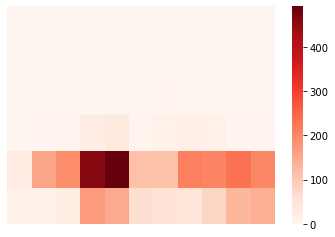

In [7]:
import io
buf = io.BytesIO()
fig = plt.Figure()
sns.heatmap(detect_heatmap_partition, xticklabels=False, yticklabels=False, cmap='Reds')
plt.savefig(buf, dpi=300, format='jpg')

In [11]:
buf.getvalue()

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x04\xb0\x07\x08\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xd2\xd3\xd4\xd

In [8]:
dir(fig)

['_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_axes_internal',
 '_agg_filter',
 '_align_label_groups',
 '_alpha',
 '_animated',
 '_axobservers',
 '_axstack',
 '_button_pick_id',
 '_cachedRenderer',
 '_callbacks',
 '_canvas_callbacks',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_constrained',
 '_constrained_layout_pads',
 '_default_contains',
 '_dpi',
 '_gci',
 '_get_clipping_extent_bbox',
 '_get_dpi',
 '_get_draw_artists',
 '_gid',
 '_gridspecs',
 '_in_layout',
 '_label',
 '_localaxes',
 '_mouseover',
 '_normalize_grid_string',
 '_original_dpi',
 '_path_effects',
 '_picker',
 '_process_projection_r

In [9]:
dir(fig.canvas)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_button',
 '_device_pixel_ratio',
 '_fix_ipython_backend2gui',
 '_get_output_canvas',
 '_idle_draw_cntx',
 '_is_idle_drawing',
 '_is_saving',
 '_key',
 '_lastx',
 '_lasty',
 '_set_device_pixel_ratio',
 '_timer_cls',
 'blit',
 'button_pick_id',
 'button_press_event',
 'button_release_event',
 'callbacks',
 'close_event',
 'device_pixel_ratio',
 'draw',
 'draw_event',
 'draw_idle',
 'enter_notify_event',
 'events',
 'figure',
 'filetypes',
 'fixed_dpi',
 'flush_events',
 'get_default_filename',
 'get_default_filetype',
 'get_supported_filetypes',
 'get_supported_filetypes_grouped',
 'get_width_height',
 'get_window_title',

In [10]:
fig.canvas.tostring_rgb()

AttributeError: 'FigureCanvasBase' object has no attribute 'tostring_rgb'